<a href="https://colab.research.google.com/github/geoffcorvera/deeplearning-spring2021/blob/main/MNIST_Fashion_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [165]:
import tensorflow as tf
from tensorflow import keras
import numpy as np 
import matplotlib.pyplot as plt 
from tensorflow.keras import layers
from keras.datasets.fashion_mnist import load_data

# Define Generator Model


*   Input: 100-dimensional sample from Gaussian latent space

*   First dense layer: 100 neurons (followed by BatchNormalization & LeakyRELU)
*   Intermediate layer: 500 dense (followed by BatchNormalization & LeakyRELU)
*   Last dense layer: 784 (neurons) (sigmoid activation)
*   Reshape into desired image shape 

*   Output: Generated image (28x28)



In [182]:
img_shape = (28,28,1)

def Generator(latent_dims=100):
  noise = keras.Input(latent_dims)

  x = layers.Dense(256, use_bias=False)(noise)
  x = layers.LeakyReLU()(x)
  x = layers.BatchNormalization()(x)

  x = layers.Dropout(0.25)(x)
  x = layers.Dense(512)(x)
  x = layers.LeakyReLU()(x)
  x = layers.BatchNormalization()(x)

  x = layers.Dropout(0.25)(x)
  x = layers.Dense(28*28, activation='sigmoid')(x)

  generated_img = layers.Reshape(img_shape)(x)
  generator = keras.Model(noise, generated_img, name='generator')

  return generator

In [183]:
g_model = Generator()
g_model.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_78 (InputLayer)        [(None, 100)]             0         
_________________________________________________________________
dense_61 (Dense)             (None, 256)               25600     
_________________________________________________________________
leaky_re_lu_162 (LeakyReLU)  (None, 256)               0         
_________________________________________________________________
batch_normalization_161 (Bat (None, 256)               1024      
_________________________________________________________________
dropout_98 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_62 (Dense)             (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_163 (LeakyReLU)  (None, 512)               0 

# Define Descriminator Model

Tries to mirror the generator network.

In [184]:
def Discriminator(input_shape=img_shape):
  input_img = keras.Input(input_shape)

  x = layers.Flatten()(input_img)
  x = layers.Dense(512)(x)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU()(x)

  x = layers.Dropout(0.25)(x)
  x = layers.Dense(256)(x)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU()(x)

  x = layers.Dropout(0.25)(x)
  p_real = layers.Dense(1, activation='sigmoid')(x)

  discriminator = keras.Model(input_img, p_real, name='discriminator')

  adam = keras.optimizers.Adam(learning_rate=.0002, beta_1=0.5)
  discriminator.compile(
    optimizer = adam,
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
  )

  return discriminator

In [185]:
d_model = Discriminator()
d_model.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_79 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
flatten_20 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_64 (Dense)             (None, 512)               401920    
_________________________________________________________________
batch_normalization_163 (Bat (None, 512)               2048      
_________________________________________________________________
leaky_re_lu_164 (LeakyReLU)  (None, 512)               0         
_________________________________________________________________
dropout_100 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_65 (Dense)             (None, 256)             

# Define GAN
The complete GAN model composes the generator and discriminator networks. The weights for the discriminator model are frozen before compiling the GAN model to enable training the generator weights independently. Binary cross-entropy is used for the loss function. Adam optimizer is used with a learning rate of 0.0002 and beta 1 of 0.5.


In [186]:
def makeGAN(g_model, d_model, latent_dims=100):
  d_model.trainable = False

  latent_sample = keras.Input(shape=(latent_dims,1))
  generated_img = g_model(latent_sample)
  p_real = d_model(generated_img)
  gan = keras.Model(latent_sample, p_real, name='gan')

  adam = keras.optimizers.Adam(learning_rate=.0002, beta_1=0.5)
  gan.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
  gan.summary()

  return gan

In [187]:
gan = makeGAN(g_model, d_model)

Model: "gan"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_80 (InputLayer)        [(None, 100, 1)]          0         
_________________________________________________________________
generator (Functional)       (None, 28, 28, 1)         562448    
_________________________________________________________________
discriminator (Functional)   (None, 1)                 536577    
Total params: 1,099,025
Trainable params: 560,912
Non-trainable params: 538,113
_________________________________________________________________


# Load & Preprocess MNIST Fashion Dataset

We load the training and test data as numpy arrays for the MNIST fashion dataset. The pixel intensities of the training and test images are rescaled to [0,1] by dividing intensities by max value (255). An extra dimension is added to each example, to specify image is single-channel.

In [119]:
def load_mnist():
  (trainx, _), (_, _) = load_data()
  trainx = np.expand_dims(trainx, axis=-1)
  trainx = trainx / 255.

  print('Train summary', trainx.shape, trainx.dtype)

  return trainx

In [120]:
train_set = load_mnist()

Train summary (60000, 28, 28, 1) float64


# Generating Data for Training
Our goal is to train the discriminator network to output the probability that an input image is real. To this end, we need to train the discriminator on a combination of real and fake/generated images. We give the real examples a target of 1, and fake/generated examples a target of 0.

In [188]:
def generate_real_samples(dataset, n_samples):
  # randomly sample examples from the dataset
  indices = np.random.randint(0, len(dataset), n_samples),
  samples = dataset[indices]
  labels = np.ones((n_samples,1))

  assert samples.shape[0] == labels.shape[0]
  assert samples.shape[0] == n_samples
  
  return samples, labels

# Make n_samples number of fake images (28x28)
def generate_fake_samples(n_samples, g_model=None):
  if (g_model):
    z = generate_latent_points(n_samples)
    X = g_model(z)
  else:
    X = np.random.rand(28*28*n_samples)
    X = X.reshape((n_samples,28,28,1))

  y = np.zeros((n_samples,1))
  assert X.shape[0] == y.shape[0]

  return X, y

def generate_latent_points(n_samples, latent_dims=100):
  X = np.random.rand(n_samples * latent_dims)
  X = X.reshape(n_samples, latent_dims)
  return X

# Training Network

In [190]:
checkpoint_path = 'gan-checkpoints/cp-{epoch:04d}.ckpt'
batch_size = 32

# TODO: set epochs to 100
def train(gan, d_model, dataset, batch_size=batch_size, n_epochs=3):
  n_batches = len(dataset) // batch_size
  n_half = batch_size // 2

  d_loss_per_epoch = []
  gan_loss_per_epoch = []
  d_acc_per_epoch = []
  gan_acc_per_epoch = []

  for i in range(n_epochs):
    d_loss = 0
    g_loss = 0
    d_acc = 0
    g_acc = 0

    for iter in range(n_batches):
      x_fake, y_fake = generate_fake_samples(n_half, gan.get_layer('generator'))

      if (iter % 250 == 0):
          plt.imshow(x_fake[0,:,:,0], cmap='gray')
          plt.suptitle(f'epoch: {i}\batch: {iter}')
          plt.show()
      
      x_real, y_real = generate_real_samples(dataset, n_half)
      # Combine real and fake into single training batch
      X = np.vstack([x_fake, x_real])
      y = np.vstack([y_fake, y_real])

      # # add random noise to labels
      # y += np.random.uniform(y.shape[0])

      # shuffle batch
      mask = np.arange(X.shape[0])
      np.random.shuffle(mask)
      X = X[mask]
      y = y[mask]
      dl, da = d_model.train_on_batch(X,y)
      
      x_gan = generate_latent_points(batch_size)
      y_gan = np.ones((batch_size,1))
      gl, ga = gan.train_on_batch(x_gan, y_gan)

      d_loss += dl
      g_loss += gl
      d_acc = (d_acc + da) / (iter+1)
      g_acc = (g_acc + ga) / (iter+1)

    d_loss_per_epoch.append(d_loss)
    gan_loss_per_epoch.append(g_loss)
    d_acc_per_epoch.append(d_acc)
    gan_acc_per_epoch.append(g_acc)
    
    gan.save_weights(checkpoint_path)

  
  return (d_loss_per_epoch, d_acc_per_epoch, gan_loss_per_epoch, gan_acc_per_epoch)

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8 missing from current font.
  font.set_text(s, 0, flags=flags)


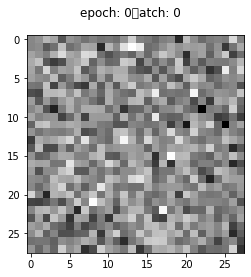

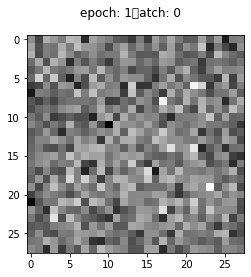

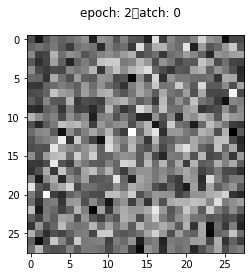

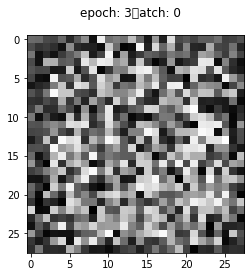

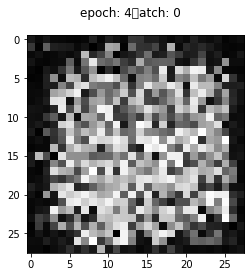

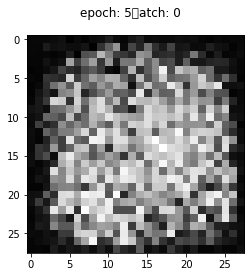

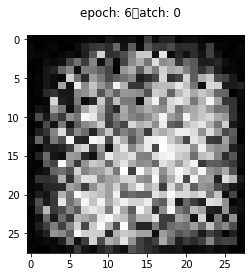

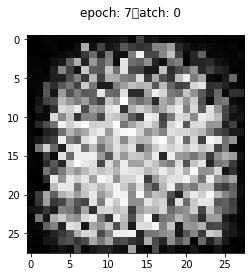

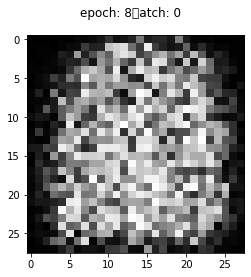

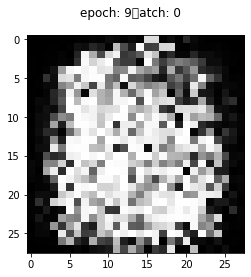

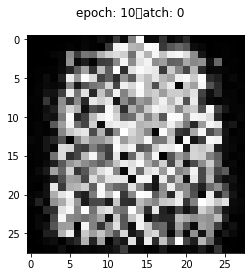

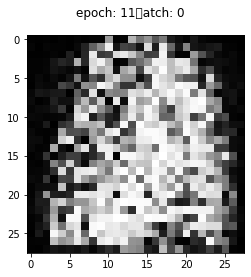

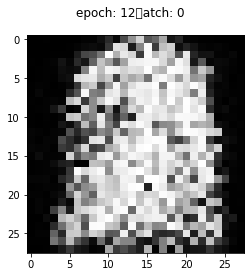

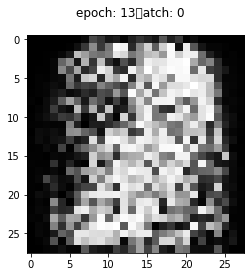

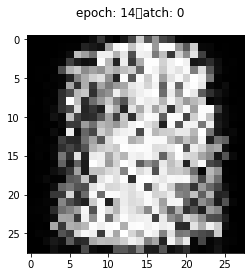

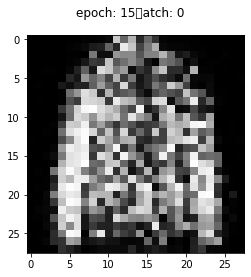

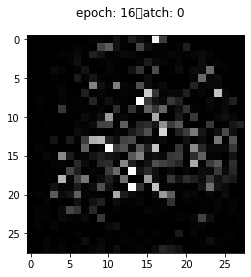

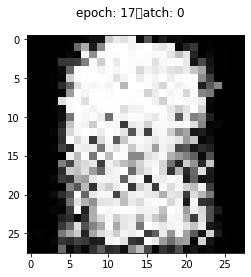

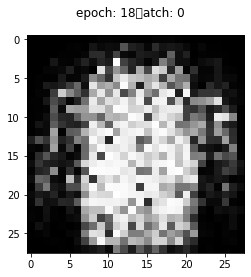

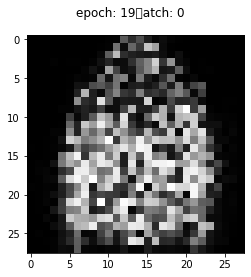

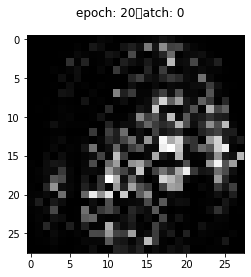

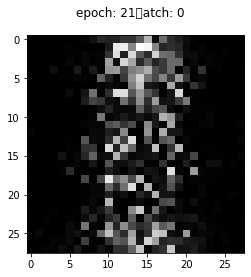

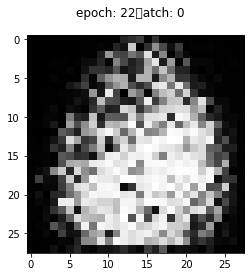

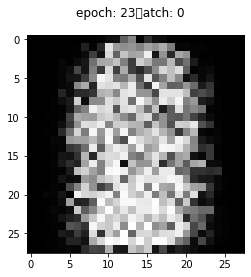

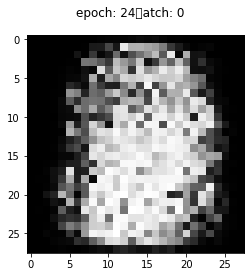

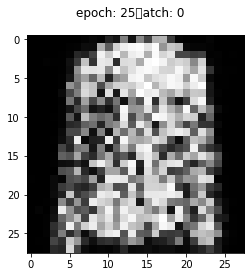

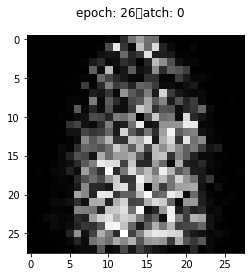

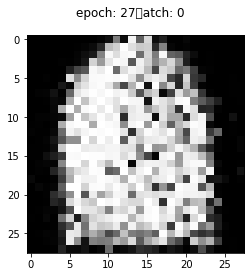

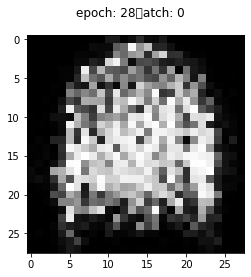

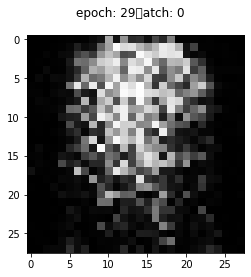

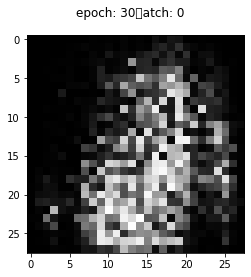

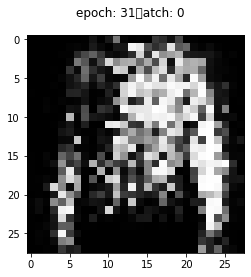

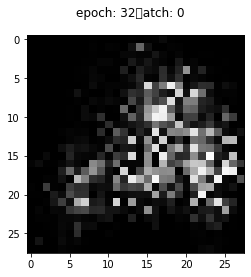

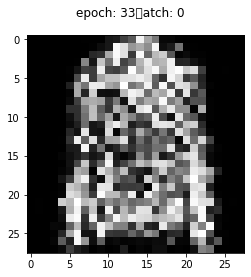

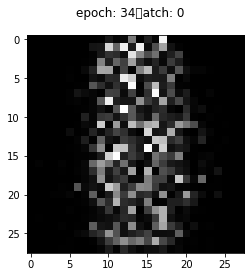

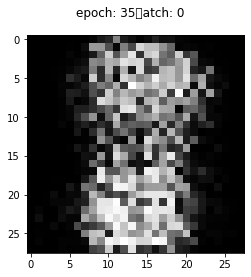

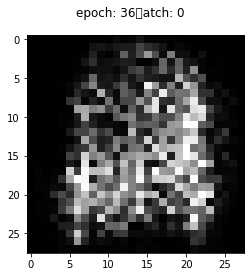

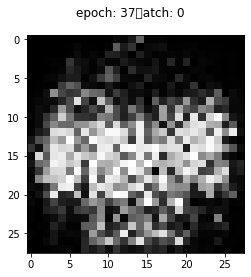

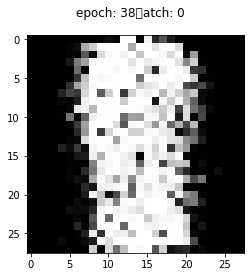

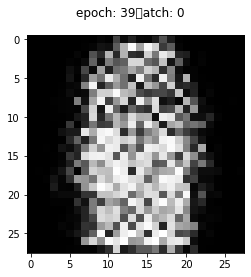

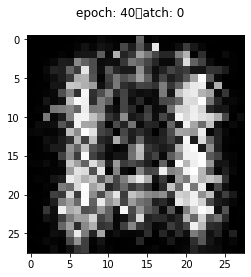

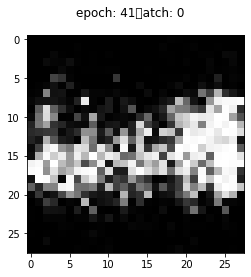

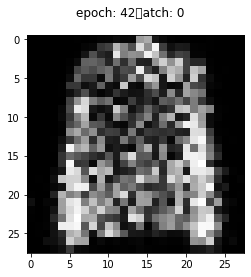

In [ ]:
# training_size = batch_size*128
training_size = 3000
dloss, dacc, gloss, gacc = train(
    gan,
    d_model,
    train_set[:training_size],
    n_epochs=100
)
gan.save('/models/mnist_gan_quarter_data_v2/')

In [ ]:
# Plot Discriminator & GAN training losses
ax = plt.subplot(2,1,1)
line = plt.plot(range(len(dloss)), dloss)
line.set_title('D loss')
line = plt.plot(range(len(gloss)), gloss, 'r')()
line.set_title('GAN loss')
ax.legend()

# Plot Discriminator & GAN training accuracy(?)
ax = plt.subplot(2,1,2)
line = plt.plot(range(len(dacc)), dacc)
line.set_title('D accuracy')
line = plt.plot(range(len(gacc)), gacc, 'r')
line.set_title('GAN accuracy')
ax.legend()

plt.suptitle('Losses & Accuracies')
plt.show()

In [ ]:
def generateImages(g_model):
  Z = generate_latent_points(10)
  generated_imgs = g_model(Z)

  for i in range(10):
    plt.subplot(2,5,1+i)
    plt.imshow(generated_imgs[i][:,:,0], cmap='gray')
    plt.axis('off')

  plt.suptitle('Generated Images')
  plt.show()

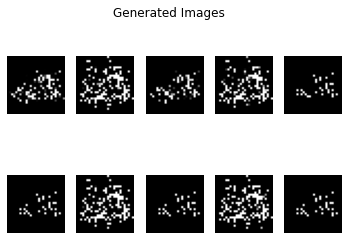

In [ ]:
# 3rd iteration: dataset size = batch_size*128
generateImages(gan.get_layer('generator'))

# Define Convolutional Models
The deep convolutional GAN replaces the Dense layers used  in the previous models with convolutional and transpose convolution layers.

The generator upsamples a 100-dimensional vector sampled from a latent space with a Gaussian distribution. Transpose convolutional layers upsamples to a dimension of 28 x 28 single-channel image.

The generator model uses dropout, batch normalization and Leaky ReLU activations in the hidden layers with the following parameters:
*   Batch normalization momentum = 0.8
*   Leaky ReLU slope = 0.2
*   Dropout with probability of 0.25
*   Transpose convolution filter size 5, stride 2
*   The final transpose convolution layer uses a sigmoid activation function

The discriminator model uses the same parameters for dropout, BN, and leaky ReLU. The convolutional layers also have filter size of 5 and stride of 2. The output layer is a Dense layer with a single neuron and sigmoid activation function. The output layer represents the probabilty that the input image is a real image.

The descriminator model is compiled with adam optimizer (learning rate = 0.0002 & beta_1 = 0.5), and binary cross-entropy loss to allow the descriminator to be trained in a standalone fashion.

The final DF-GAN model is created with the conv generator and discriminator models in the same fashion as the Dense GAN.


In [96]:
def ConvGenerator(latent_dims=100):
  inputs = keras.Input(latent_dims)

  x = layers.Dense(5*5*64)(inputs)
  x = layers.LeakyReLU(alpha=0.2)(x)
  x = layers.BatchNormalization(momentum=0.8)(x)
  x = layers.Reshape((5,5,64))(x)

  x = layers.Dropout(0.25)(x)
  x = layers.Conv2DTranspose(64,5,strides=2)(x)
  x = layers.ZeroPadding2D(padding=((0,1),(0,1)))(x)
  x = layers.LeakyReLU(alpha=0.2)(x)
  x = layers.BatchNormalization(momentum=0.8)(x)

  outputs = layers.Conv2DTranspose(1,5,strides=2,activation='sigmoid',padding='same')(x)

  G = keras.Model(inputs, outputs, name='generator')
  G.summary()

  return G

In [97]:
img_shape = (28,28,1)
def ConvDiscriminator(input_shape=img_shape):
  inputs = keras.Input(input_shape)

  x = layers.Conv2D(64,5,strides=2,padding='same')(inputs)
  x = layers.LeakyReLU(alpha=0.2)(x)
  x = layers.BatchNormalization(momentum=0.8)(x)

  x = layers.Dropout(0.25)(x)
  x = layers.Conv2D(128,5,strides=2,padding='same')(x)
  x = layers.LeakyReLU(alpha=0.2)(x)
  x = layers.BatchNormalization(momentum=0.8)(x)

  x = layers.Dropout(0.25)(x)
  x = layers.Flatten()(x)
  outputs = layers.Dense(1, activation='sigmoid')(x)
  D = keras.Model(inputs, outputs, name='convDiscriminator')

  adam = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
  D.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
  D.summary()

  return D

# Create & Train Convolutional Model

In [ ]:
convD = ConvDiscriminator()
convG = ConvGenerator()
dcgan = makeGAN(g_model=convG, d_model=convD)

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8 missing from current font.
  font.set_text(s, 0, flags=flags)


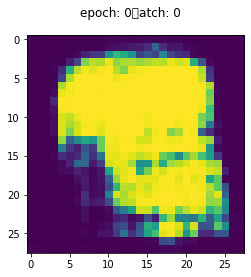

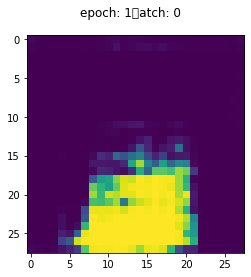

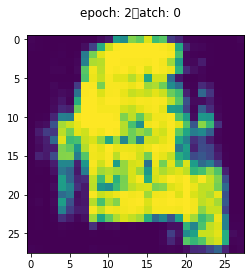

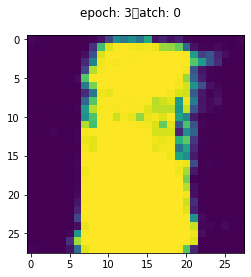

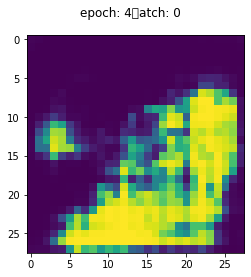

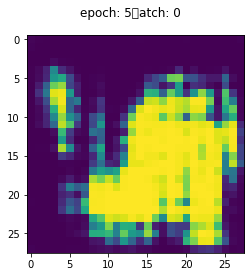

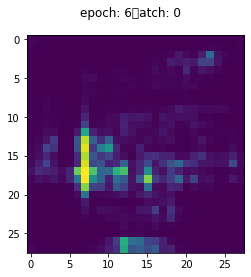

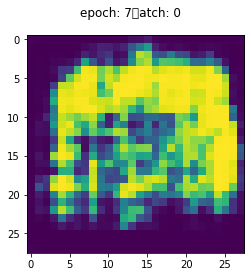

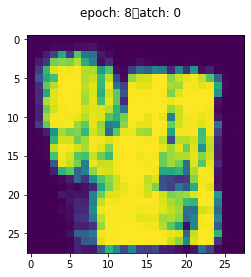

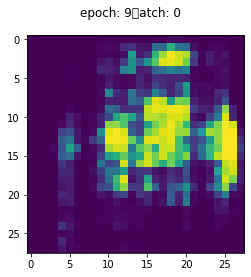

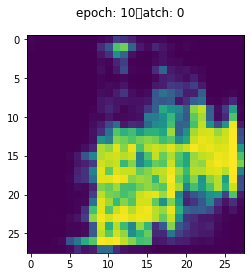

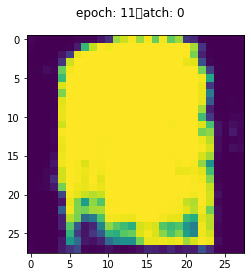

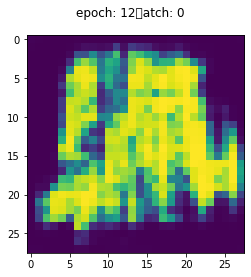

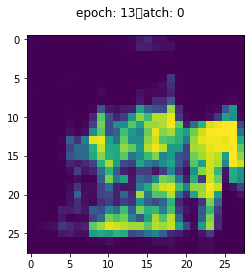

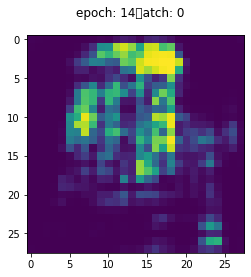

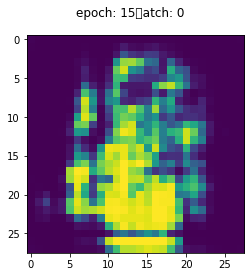

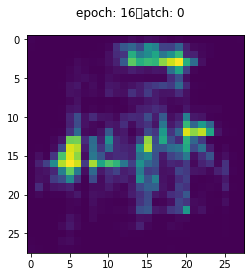

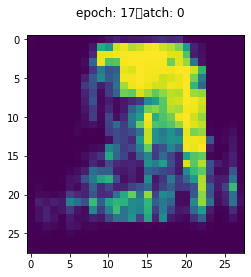

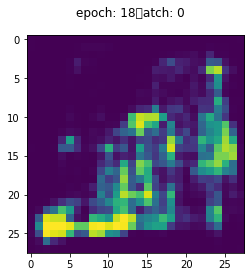

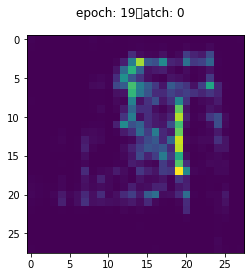

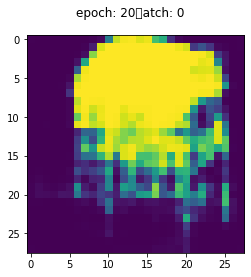

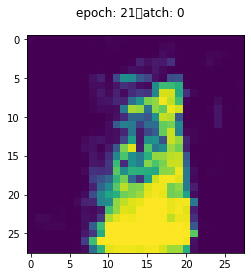

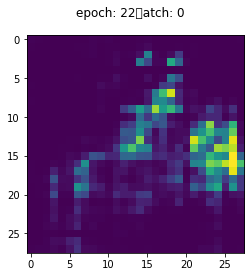

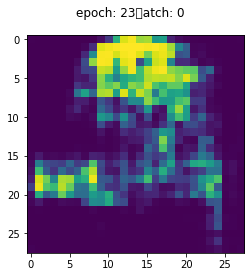

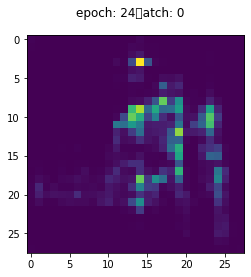

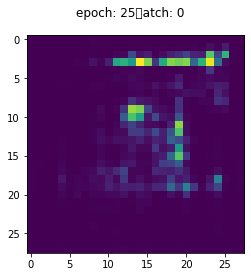

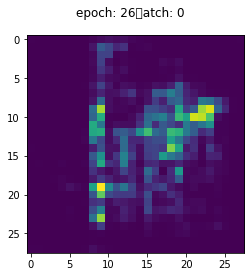

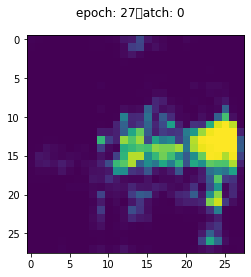

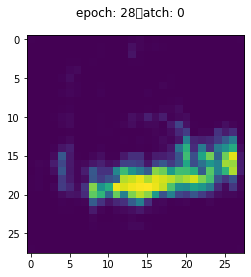

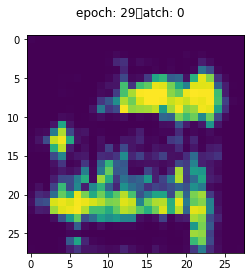

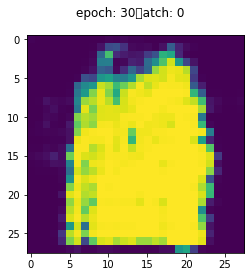

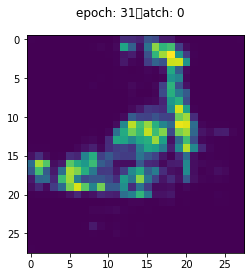

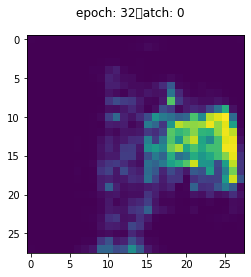

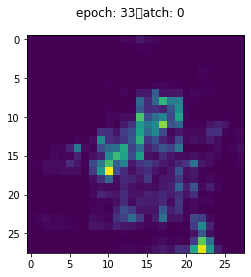

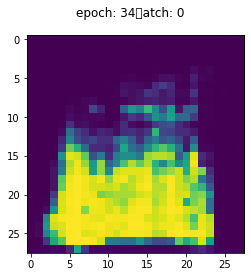

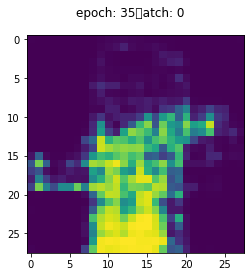

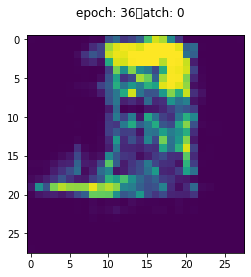

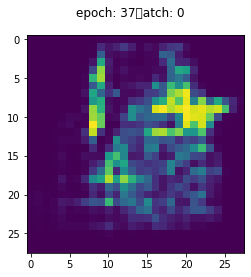

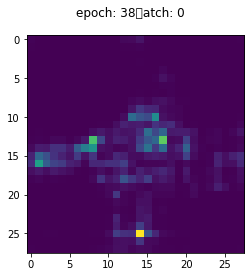

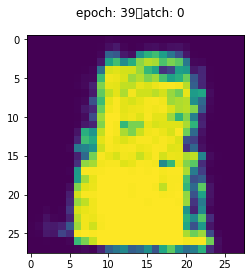

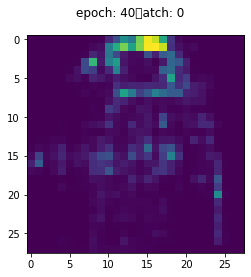

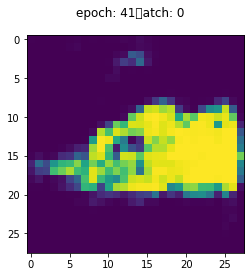

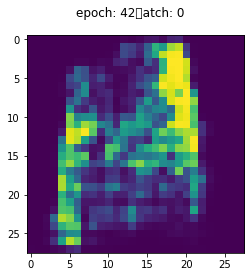

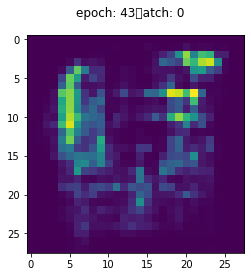

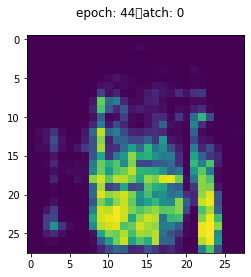

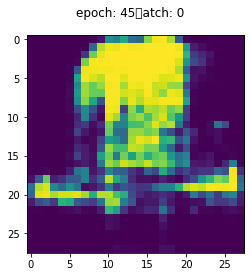

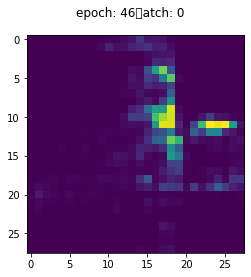

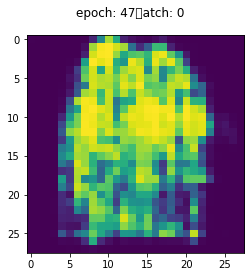

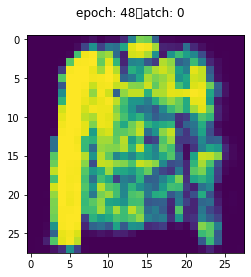

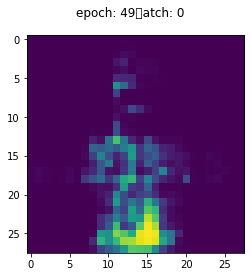

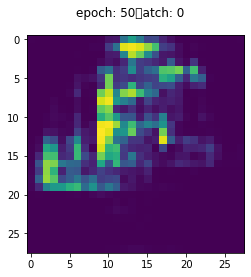

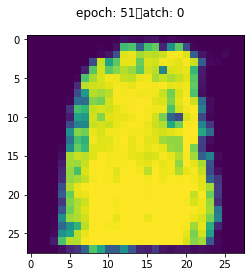

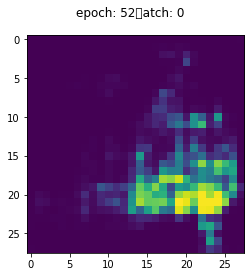

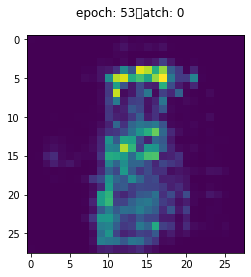

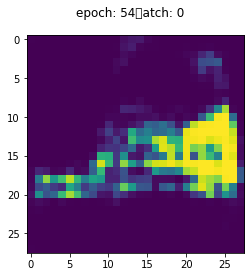

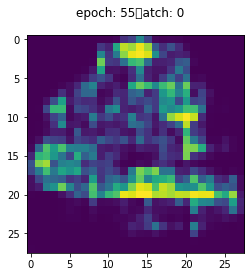

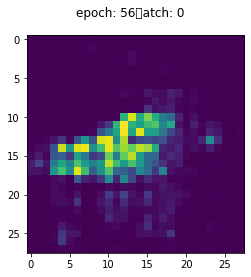

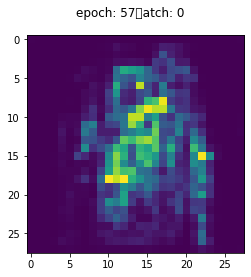

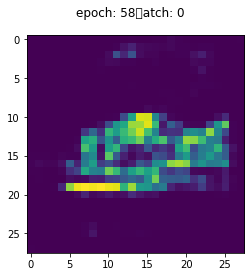

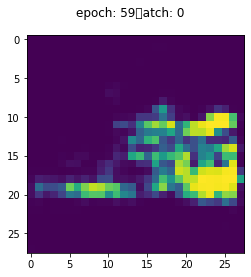

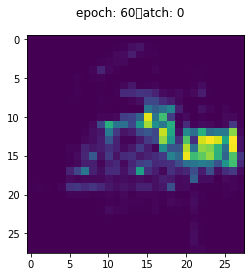

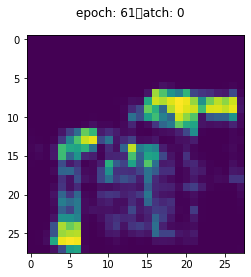

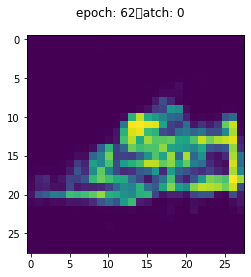

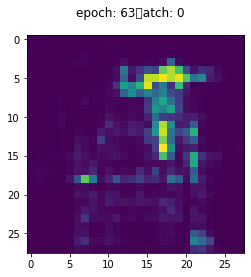

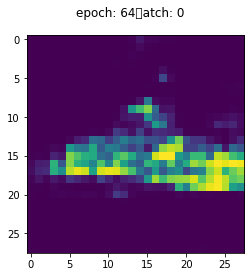

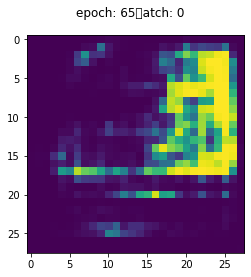

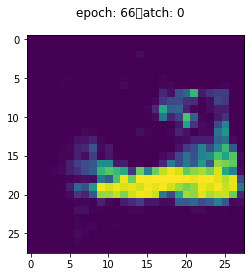

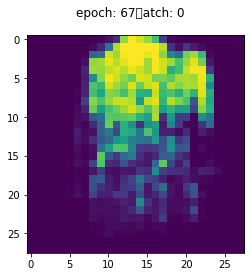

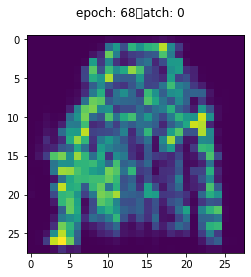

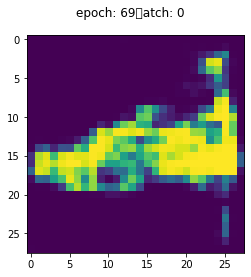

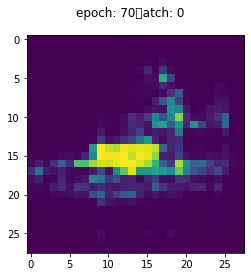

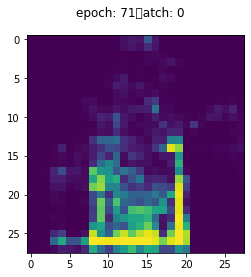

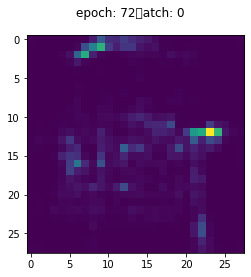

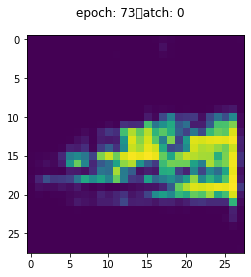

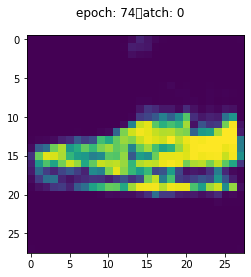

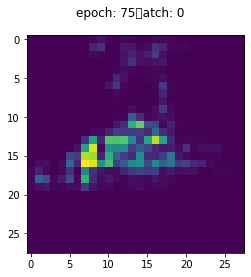

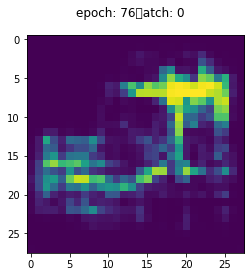

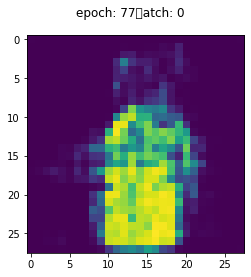

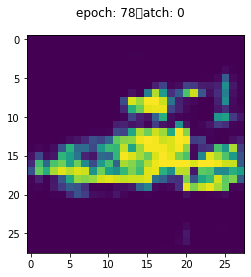

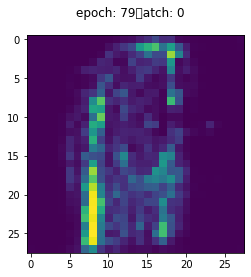

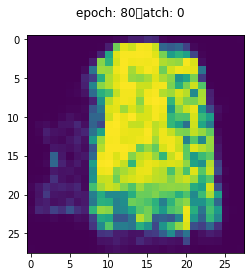

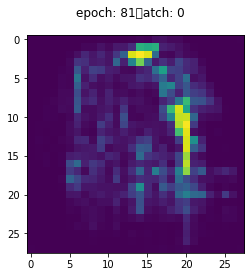

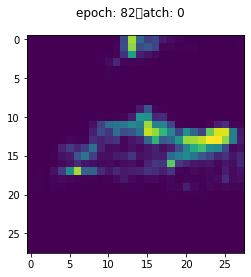

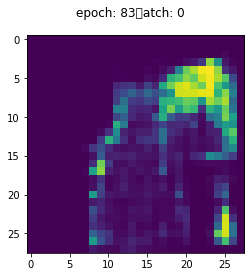

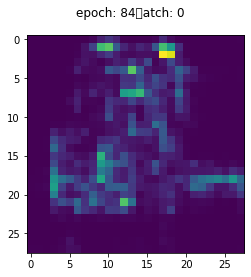

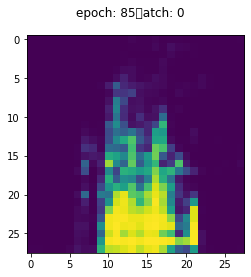

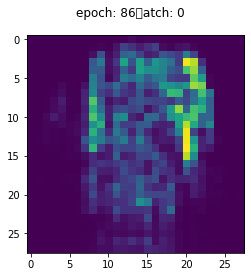

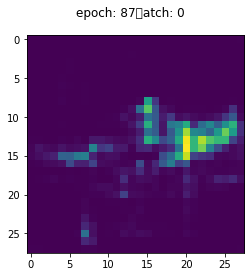

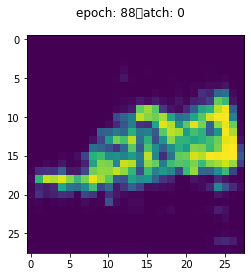

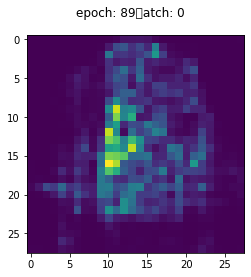

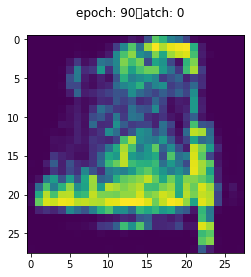

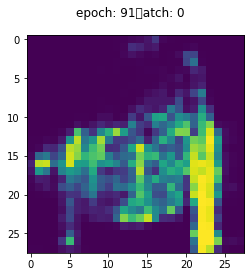

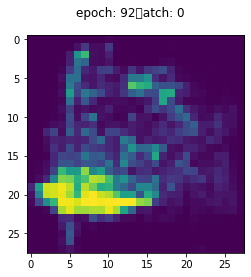

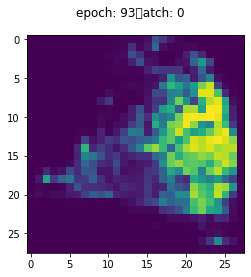

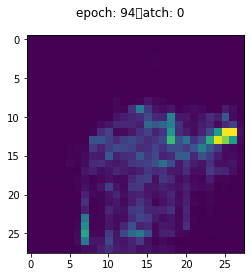

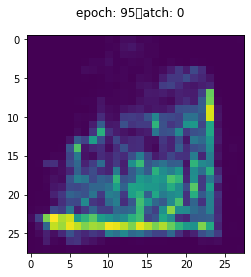

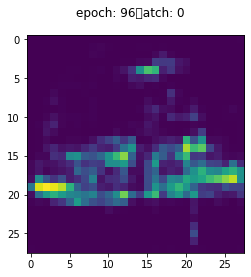

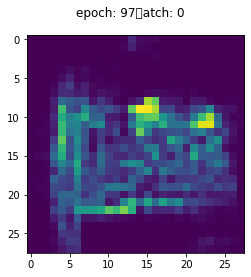

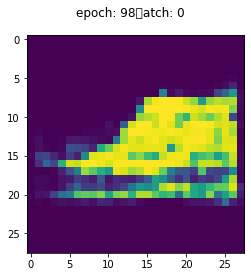

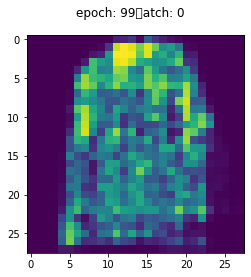

In [162]:
d_loss, d_acc, g_loss, g_acc = train(dcgan, convD, train_set[:1000],n_epochs=100)
# TODO load and save weights

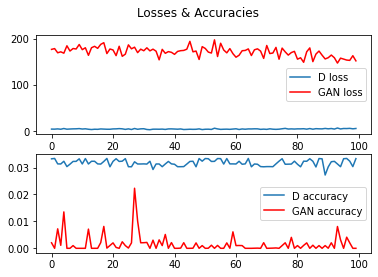

In [163]:
# Plot Discriminator & GAN training losses
ax = plt.subplot(2,1,1)
dl_line, = plt.plot(range(len(d_loss)), d_loss)
dl_line.set_label('D loss')
gl_line, = plt.plot(range(len(g_loss)), g_loss, 'r')
gl_line.set_label('GAN loss')
ax.legend()

# Plot Discriminator & GAN training accuracy(?)
ax = plt.subplot(2,1,2)
line, = plt.plot(range(len(d_acc)), d_acc)
line.set_label('D accuracy')
line, = plt.plot(range(len(g_acc)), g_acc, 'r')
line.set_label('GAN accuracy')
ax.legend()

plt.suptitle('Losses & Accuracies')
plt.show()

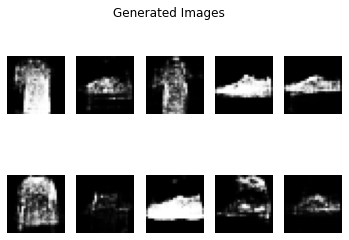

In [164]:
generateImages(dcgan.get_layer('generator'))